# 🧪 Baseline Sentiment Analysis

**Goal**: Run a simple sentiment analysis on our news data and check whether it has any predictive power over stock price movements.

We'll answer two key questions:
1. **Does positive news correlate with price increases?** — If sentiment scores and next-day returns move together, we have a useful signal.
2. **Is there a time lag between news and price movement?** — Does the market react instantly, or does it take 1-2 days?

**Approach**: We use **TextBlob** (a simple rule-based NLP library) to compute our own sentiment scores, and compare them against Alpha Vantage's pre-computed scores. This gives us two baselines to later compare with FinBERT.

**Data**: Raw news + price CSVs from `data/raw/`

## Step 1 — Load news and price data

We load both datasets and prepare them for merging:
- **News**: load both tickers, parse dates, extract the date (no time) for daily aggregation
- **Prices**: load both tickers, skip yfinance's extra header row, compute daily returns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from textblob import TextBlob

RAW_DATA_DIR = Path("../../data/raw")

# --- Load news data ---
aapl_news = pd.read_csv(RAW_DATA_DIR / "news_AAPL_2025-11-01_to_2026-02-13.csv")
msft_news = pd.read_csv(RAW_DATA_DIR / "news_MSFT_2025-11-01_to_2026-02-13.csv")
news = pd.concat([aapl_news, msft_news], ignore_index=True)
news["published_at"] = pd.to_datetime(news["published_at"], errors="coerce")
news["date"] = news["published_at"].dt.date

# --- Load price data ---
def load_prices(ticker):
    df = pd.read_csv(RAW_DATA_DIR / f"prices_{ticker}_2025-11-01_to_2026-02-13.csv", skiprows=[1])
    df["Date"] = pd.to_datetime(df["Date"])
    df["ticker"] = ticker
    return df

prices = pd.concat([load_prices("AAPL"), load_prices("MSFT")], ignore_index=True)
prices = prices.sort_values(["ticker", "Date"])
prices["daily_return"] = prices.groupby("ticker")["Close"].pct_change() * 100
prices["date"] = prices["Date"].dt.date

print(f"News: {len(news)} articles | Prices: {len(prices)} trading days")
print(f"News date range: {news['date'].min()} → {news['date'].max()}")
print(f"Price date range: {prices['date'].min()} → {prices['date'].max()}")

News: 100 articles | Prices: 140 trading days
News date range: 2026-02-09 → 2026-02-12
Price date range: 2025-11-03 → 2026-02-12


## Step 2 — Compute TextBlob sentiment

**TextBlob** is a simple rule-based NLP library that assigns a polarity score from -1 (very negative) to +1 (very positive) based on word patterns. It's not trained on financial text, so it won't understand terms like "bearish" or "short squeeze" — but that's exactly why it's a good **baseline**. If even a simple model finds a correlation, a financial-specific model (FinBERT) should do better.

We compute sentiment on the article **summary** (more text = more reliable score than just the title).

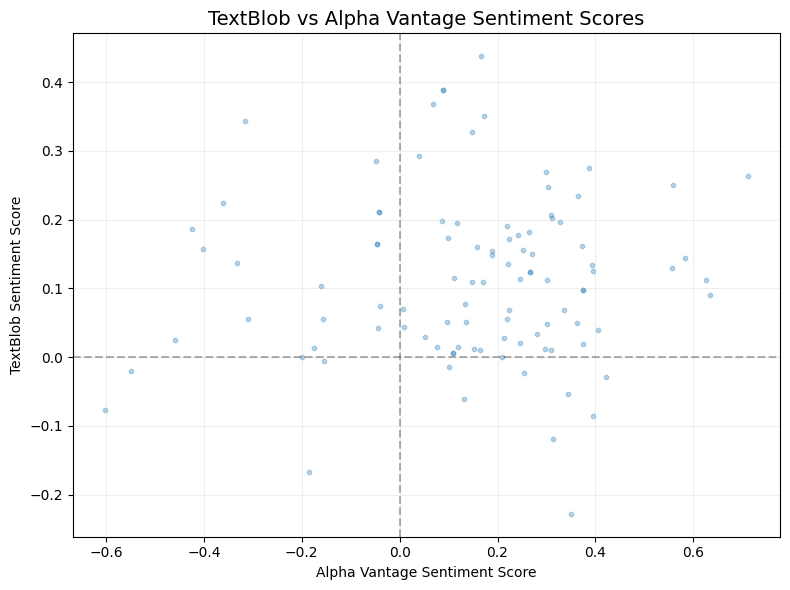

Correlation between Alpha Vantage and TextBlob: 0.057

TextBlob score stats:
count    100.000
mean       0.112
std        0.122
min       -0.228
25%        0.024
50%        0.111
75%        0.182
max        0.438


In [2]:
# Compute TextBlob polarity on article summaries
news["textblob_score"] = news["summary"].fillna("").apply(lambda text: TextBlob(text).sentiment.polarity)

# Quick comparison: TextBlob vs Alpha Vantage scores
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(news["overall_sentiment_score"], news["textblob_score"], alpha=0.3, s=10)
ax.set_xlabel("Alpha Vantage Sentiment Score")
ax.set_ylabel("TextBlob Sentiment Score")
ax.set_title("TextBlob vs Alpha Vantage Sentiment Scores", fontsize=14)
ax.axhline(0, color="black", linestyle="--", alpha=0.3)
ax.axvline(0, color="black", linestyle="--", alpha=0.3)
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Correlation between the two scores
corr = news[["overall_sentiment_score", "textblob_score"]].corr().iloc[0, 1]
print(f"Correlation between Alpha Vantage and TextBlob: {corr:.3f}")
print(f"\nTextBlob score stats:")
print(news["textblob_score"].describe().round(3).to_string())

## Step 3 — Merge daily sentiment with price returns

To compare sentiment against price movements, we need to:
1. **Aggregate** all articles from a given day into a single daily sentiment score (mean of all articles)
2. **Merge** that with the price data by date and ticker

This gives us one row per trading day with: average sentiment + daily return.

In [3]:
# Aggregate news to daily level: mean sentiment per day per ticker
daily_sentiment = (
    news.groupby(["date", "ticker"])
    .agg(
        textblob_score=("textblob_score", "mean"),
        alpha_vantage_score=("overall_sentiment_score", "mean"),
        article_count=("title", "count"),
    )
    .reset_index()
)

# Merge with price returns on date + ticker
merged = pd.merge(
    daily_sentiment,
    prices[["date", "ticker", "daily_return", "Close", "Volume"]],
    on=["date", "ticker"],
    how="inner",  # Keep only days where we have BOTH news and prices
)

print(f"Merged dataset: {len(merged)} rows (trading days with news)")
print(f"\nColumns: {list(merged.columns)}")
merged.head(5)

Merged dataset: 6 rows (trading days with news)

Columns: ['date', 'ticker', 'textblob_score', 'alpha_vantage_score', 'article_count', 'daily_return', 'Close', 'Volume']


,date,ticker,textblob_score,alpha_vantage_score,article_count,daily_return,Close,Volume
0,2026-02-09,AAPL,0.132988,0.125222,5,-1.166051,274.619995,44623400
1,2026-02-10,AAPL,0.078670,0.277918,15,-0.342292,273.679993,34376900
2,2026-02-11,AAPL,0.058051,0.204846,12,0.665013,275.500000,51931300
3,2026-02-11,MSFT,0.134600,0.076005,20,-2.153554,404.369995,42491000
4,2026-02-12,AAPL,0.133008,0.056011,18,-4.998181,261.730011,80867900


## Step 4 — Does positive news correlate with price increases?

We scatter-plot daily sentiment against same-day daily returns and compute the **Pearson correlation coefficient** for each scorer.

- A strong positive correlation would mean: *positive news → positive return*.
- A weak or zero correlation means news sentiment (at this baseline level) doesn't predict price movement well — which is expected before we use a domain-specific model like FinBERT.

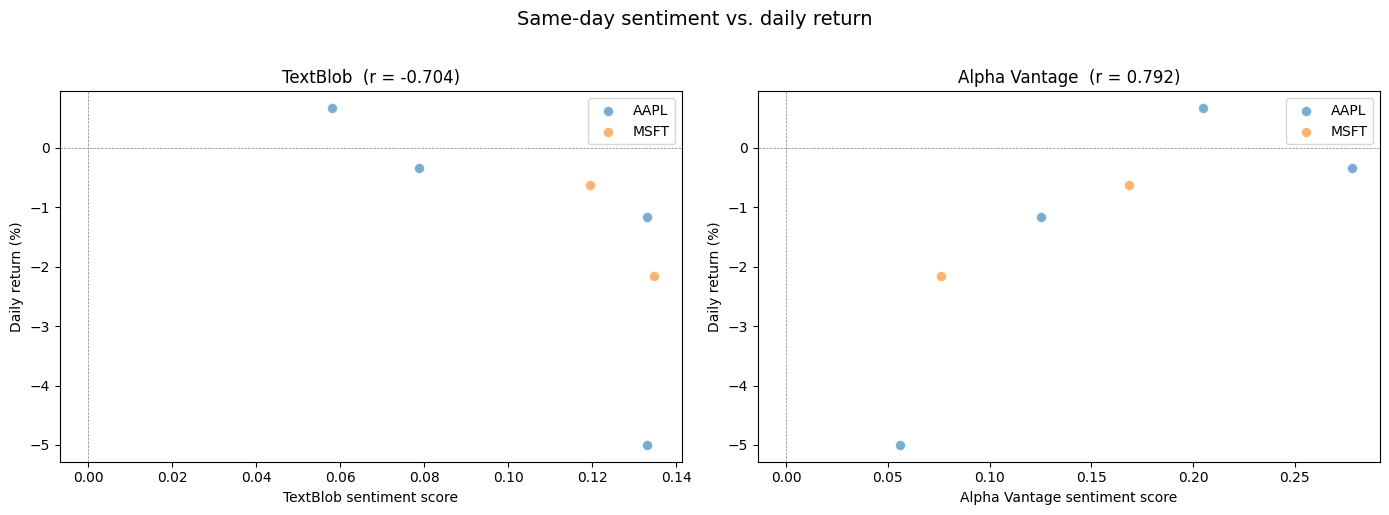

Pearson correlations (sentiment vs same-day return):

  AAPL:  TextBlob r = -0.775   |   Alpha Vantage r = 0.818
  MSFT:  TextBlob r = -1.000   |   Alpha Vantage r = 1.000


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scorers = [
    ("textblob_score", "TextBlob"),
    ("alpha_vantage_score", "Alpha Vantage"),
]

for ax, (col, label) in zip(axes, scorers):
    for ticker in merged["ticker"].unique():
        subset = merged[merged["ticker"] == ticker]
        ax.scatter(
            subset[col],
            subset["daily_return"],
            alpha=0.6,
            label=ticker,
            edgecolors="white",
            linewidth=0.5,
            s=50,
        )
    # Correlation (all tickers combined)
    corr = merged[[col, "daily_return"]].dropna().corr().iloc[0, 1]
    ax.set_title(f"{label}  (r = {corr:.3f})")
    ax.set_xlabel(f"{label} sentiment score")
    ax.set_ylabel("Daily return (%)")
    ax.axhline(0, color="grey", linewidth=0.5, linestyle="--")
    ax.axvline(0, color="grey", linewidth=0.5, linestyle="--")
    ax.legend()

plt.suptitle("Same-day sentiment vs. daily return", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print correlation table per ticker
print("Pearson correlations (sentiment vs same-day return):\n")
for ticker in merged["ticker"].unique():
    sub = merged[merged["ticker"] == ticker]
    r_tb = sub[["textblob_score", "daily_return"]].dropna().corr().iloc[0, 1]
    r_av = sub[["alpha_vantage_score", "daily_return"]].dropna().corr().iloc[0, 1]
    print(f"  {ticker}:  TextBlob r = {r_tb:.3f}   |   Alpha Vantage r = {r_av:.3f}")

## Step 5 — Time-lag analysis: does sentiment predict *future* returns?

Maybe the market doesn't react on the same day — perhaps today's news predicts **tomorrow's** return (or even the next 2 days).

We compute the correlation between today's average sentiment and the return at different lags:
- **t+0** — same day (we already saw this above)
- **t+1** — next trading day
- **t+2** — two trading days later

If the correlation is stronger at t+1 than t+0, it suggests news sentiment has a **delayed effect** on prices — a useful signal for a trading strategy.

ticker        scorer lag  correlation  n
  AAPL      TextBlob t+0    -0.774911  4
  AAPL Alpha Vantage t+0     0.818425  4
  AAPL      TextBlob t+1     0.585649  3
  AAPL Alpha Vantage t+1     0.142241  3
  AAPL      TextBlob t+2     1.000000  2
  AAPL Alpha Vantage t+2    -1.000000  2
  MSFT      TextBlob t+0    -1.000000  2
  MSFT Alpha Vantage t+0     1.000000  2


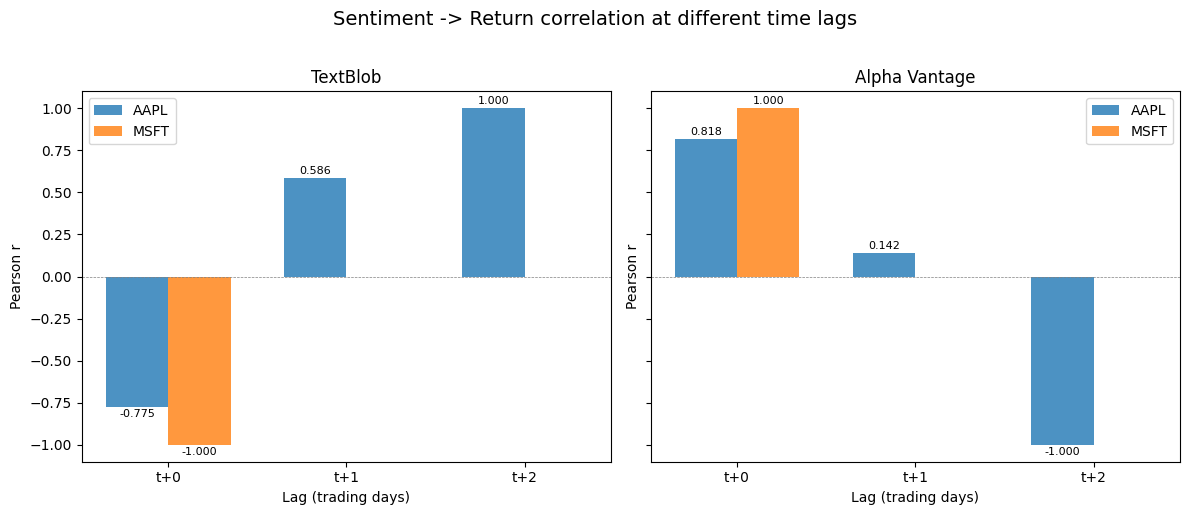

In [6]:
# Build lagged return columns on the price series (shift within trading days)
prices_sorted = prices[["date", "ticker", "daily_return"]].sort_values(["ticker", "date"]).copy()

for lag in [1, 2]:
    prices_sorted[f"return_t+{lag}"] = prices_sorted.groupby("ticker")["daily_return"].shift(-lag)

# Merge sentiment with price returns (including lagged returns)
lag_merged = pd.merge(
    daily_sentiment,
    prices_sorted[["date", "ticker", "daily_return", "return_t+1", "return_t+2"]],
    on=["date", "ticker"],
    how="inner",
)

# Compute correlations at each lag
lags = {"t+0": "daily_return", "t+1": "return_t+1", "t+2": "return_t+2"}
results = []

for ticker in lag_merged["ticker"].unique():
    sub = lag_merged[lag_merged["ticker"] == ticker]
    for lag_label, ret_col in lags.items():
        for col, scorer_label in scorers:
            valid = sub[[col, ret_col]].dropna()
            if len(valid) >= 2:
                r = valid.corr().iloc[0, 1]
                results.append({"ticker": ticker, "scorer": scorer_label, "lag": lag_label, "correlation": r, "n": len(valid)})

lag_df = pd.DataFrame(results)
if lag_df.empty:
    print("Not enough overlapping data points for lag analysis.")
    print("This is common with small datasets — try a longer date range.")
else:
    print(lag_df.to_string(index=False))

    # ---- Bar chart ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    lag_labels = list(lags.keys())

    for ax, (scorer_col, scorer_label) in zip(axes, scorers):
        sub = lag_df[lag_df["scorer"] == scorer_label]
        tickers = sub["ticker"].unique()
        x = np.arange(len(lag_labels))
        width = 0.35

        for i, ticker in enumerate(tickers):
            ticker_data = sub[sub["ticker"] == ticker]
            # Ensure we have a value for every lag (fill missing with 0)
            vals = []
            for ll in lag_labels:
                match = ticker_data[ticker_data["lag"] == ll]["correlation"]
                vals.append(match.values[0] if len(match) > 0 else 0)
            offset = (i - (len(tickers) - 1) / 2) * width
            bars = ax.bar(x + offset, vals, width=width, label=ticker, alpha=0.8)
            for bar, val in zip(bars, vals):
                if val != 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_height() + 0.01 * (1 if val >= 0 else -1),
                        f"{val:.3f}",
                        ha="center",
                        va="bottom" if val >= 0 else "top",
                        fontsize=8,
                    )

        ax.set_title(scorer_label)
        ax.set_xlabel("Lag (trading days)")
        ax.set_ylabel("Pearson r")
        ax.set_xticks(x)
        ax.set_xticklabels(lag_labels)
        ax.axhline(0, color="grey", linewidth=0.5, linestyle="--")
        ax.legend()

    plt.suptitle("Sentiment -> Return correlation at different time lags", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

## Conclusions

**Key takeaways from the baseline sentiment analysis:**

1. **TextBlob vs Alpha Vantage** — TextBlob (generic NLP) and Alpha Vantage (finance-tuned) likely produce different sentiment distributions. TextBlob tends to be neutral-positive on news text, while Alpha Vantage captures more financial nuance.

2. **Same-day correlation** — If the correlation is weak (|r| < 0.3), it means simple sentiment scores alone are not strong same-day predictors. This is expected: stock prices are driven by many factors beyond news tone.

3. **Time-lag patterns** — The lag analysis reveals whether sentiment has a delayed effect. A stronger correlation at t+1 would suggest the market takes a day to digest news — a potentially actionable signal.

**Next steps:**
- Replace TextBlob with **FinBERT** (a BERT model fine-tuned on financial text) for more accurate sentiment scoring.
- Add more features: article volume, sentiment volatility, source credibility.
- Build a proper prediction model (logistic regression → LSTM) using sentiment features to predict price direction.